In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kafka import KafkaConsumer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Connect to Kafka and read data

In [2]:
consumer = KafkaConsumer("labeled-home-sale-events", 
                         bootstrap_servers="localhost:9092", 
                         auto_offset_reset='earliest',
                         value_deserializer=json.loads)

In [3]:
records = []

for i in tqdm(range(900_000)):
    records.append(next(consumer))

100%|████████████████████████████████████████████████████████████████████████| 900000/900000 [03:22<00:00, 4434.17it/s]


## Organize data into dataframe

In [4]:
columns = ['topic', 'partition', 'offset', 'timestamp', 'col4', 'key', 'value', 'col7', 'col8', 'col9', 'col10', 'col11']
df = pd.DataFrame.from_records(records, columns=columns)

In [5]:
df.head()

,topic,partition,offset,timestamp,col4,key,value,col7,col8,col9,col10,col11
0,labeled-home-sale-events,0,0,1694633166461,0,b'7129300520',"{'id': 7129300520, 'date': '20141013T000000', ...",[],None,10,379,-1
1,labeled-home-sale-events,0,1,1694633166962,0,b'6414100192',"{'id': 6414100192, 'date': '20141209T000000', ...",[],None,10,384,-1
2,labeled-home-sale-events,0,2,1694633167464,0,b'5631500400',"{'id': 5631500400, 'date': '20150225T000000', ...",[],None,10,378,-1
3,labeled-home-sale-events,0,3,1694633167966,0,b'2487200875',"{'id': 2487200875, 'date': '20141209T000000', ...",[],None,10,381,-1
4,labeled-home-sale-events,0,4,1694633168467,0,b'1954400510',"{'id': 1954400510, 'date': '20150218T000000', ...",[],None,10,379,-1


## Pull data out into separate dataframe

In [6]:
data = pd.DataFrame.from_records(df['value'])

In [7]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Analyze Data
**There doesn't appear to be any explicit null / NaN values**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             900000 non-null  int64  
 1   date           900000 non-null  object 
 2   price          900000 non-null  float64
 3   bedrooms       900000 non-null  int64  
 4   bathrooms      900000 non-null  float64
 5   sqft_living    900000 non-null  int64  
 6   sqft_lot       900000 non-null  int64  
 7   floors         900000 non-null  float64
 8   waterfront     900000 non-null  int64  
 9   view           900000 non-null  int64  
 10  condition      900000 non-null  int64  
 11  grade          900000 non-null  int64  
 12  sqft_above     900000 non-null  int64  
 13  sqft_basement  900000 non-null  int64  
 14  yr_built       900000 non-null  int64  
 15  yr_renovated   900000 non-null  int64  
 16  zipcode        900000 non-null  int64  
 17  lat            900000 non-nul

**Let's take a look some categorical columns to make sure no strange values exist and the distribution looks reasonable**

In [9]:
# The record with 33 bedrooms claims to have 1620 sqft_living, which doesn't make a lot of sense
# So, we will just drop records with bedrooms > 11
data['bedrooms'].value_counts().sort_index()

bedrooms
0        543
1       8297
2     114925
3     409162
4     286525
5      66625
6      11343
7       1582
8        541
9        250
10       124
11        42
33        41
Name: count, dtype: int64

In [10]:
data['bathrooms'].value_counts().sort_index()

bathrooms
0.00       418
0.50       168
0.75      3000
1.00    160615
1.25       373
1.50     60268
1.75    127078
2.00     80444
2.25     85239
2.50    223792
2.75     49322
3.00     31326
3.25     24460
3.50     30339
3.75      6442
4.00      5652
4.25      3289
4.50      4160
4.75       956
5.00       874
5.25       538
5.50       416
5.75       166
6.00       249
6.25        82
6.50        82
6.75        84
7.50        42
7.75        42
8.00        84
Name: count, dtype: int64

In [11]:
data['floors'].value_counts().sort_index()

floors
1.0    445379
1.5     79634
2.0    342592
2.5      6693
3.0     25371
3.5       331
Name: count, dtype: int64

In [12]:
data['waterfront'].value_counts().sort_index()

waterfront
0    893216
1      6784
Name: count, dtype: int64

In [13]:
data['view'].value_counts().sort_index()

view
0    811525
1     13832
2     40115
3     21244
4     13284
Name: count, dtype: int64

In [14]:
data['condition'].value_counts().sort_index()

condition
1      1247
2      7179
3    583825
4    236812
5     70937
Name: count, dtype: int64

In [15]:
# According to: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#building%20grade
# the 'Grade' should range from 1-13, which is what we see
data['grade'].value_counts().sort_index()

grade
1         41
3        126
4       1206
5      10089
6      84969
7     374285
8     252510
9     108724
10     47161
11     16598
12      3747
13       544
Name: count, dtype: int64

**Now let's look at histograms of numerical columns to see if there are any outliers or wierd distributions**

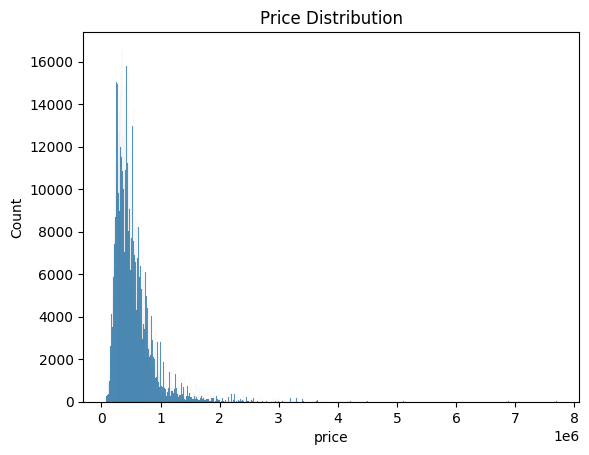

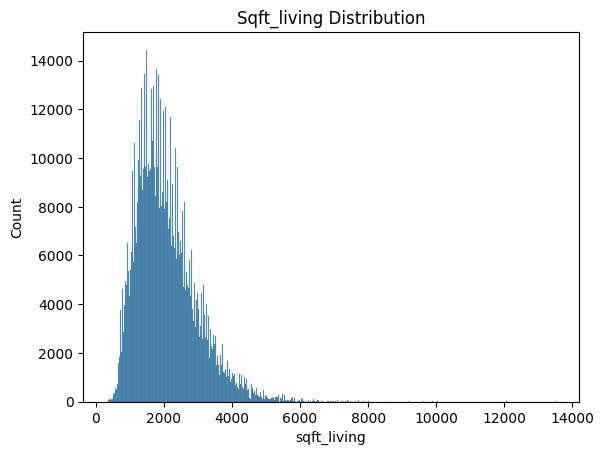

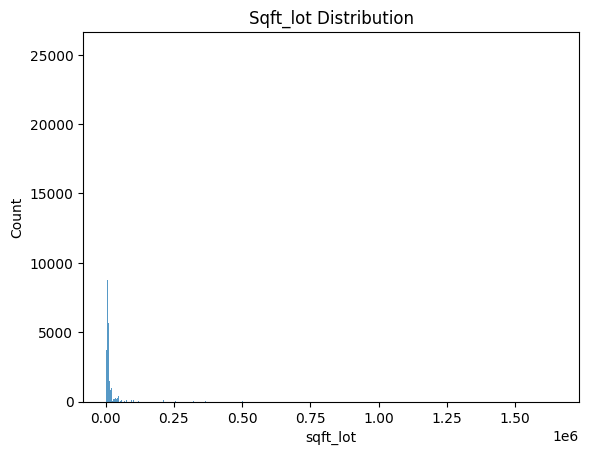

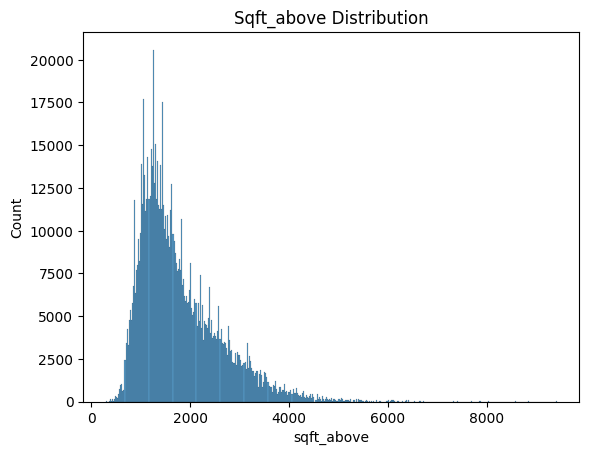

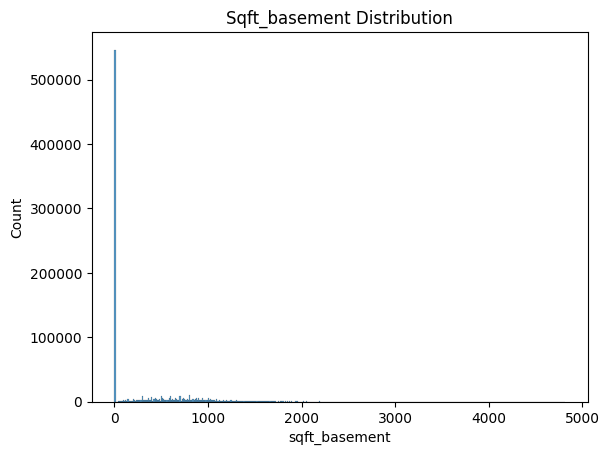

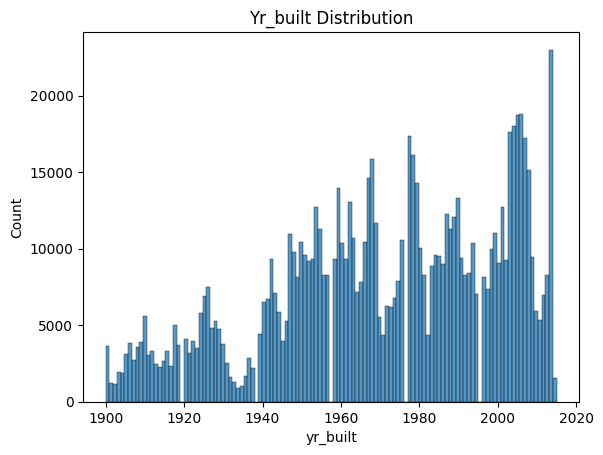

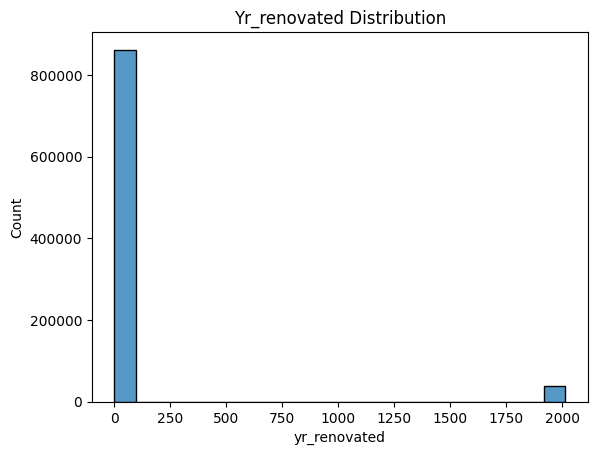

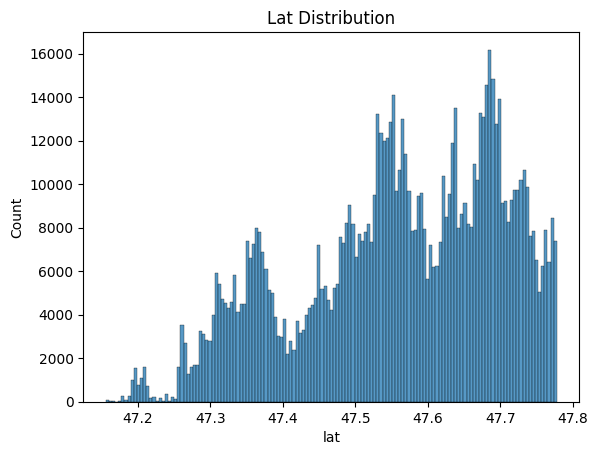

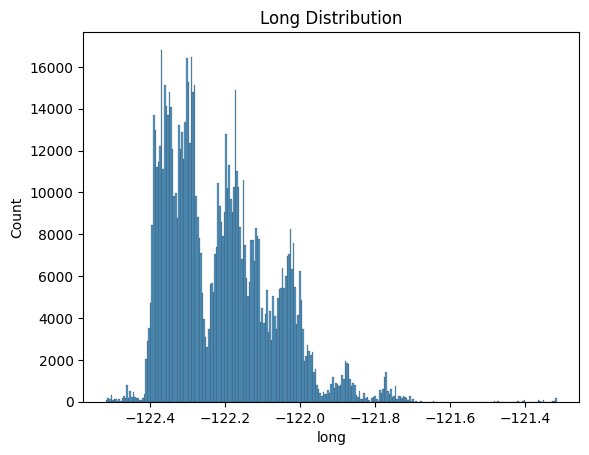

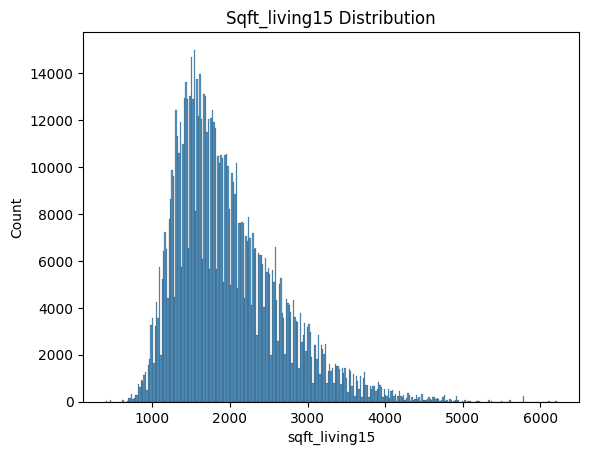

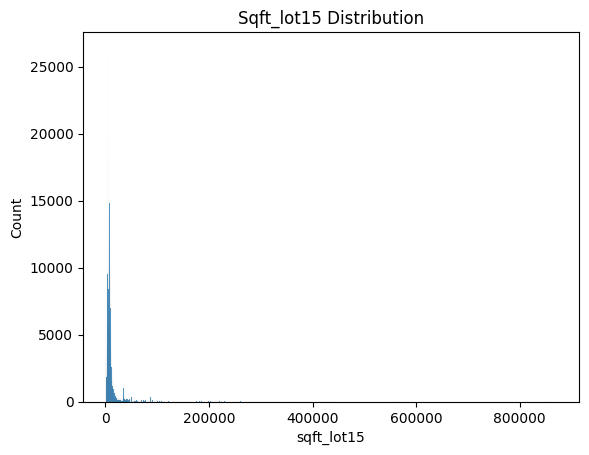

In [16]:
numeric_cols = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

for col in numeric_cols:
    sns.histplot(data[col]).set(title=f"{col.capitalize()} Distribution")
    plt.show()

While there are some very high outliers, there don't seem to be any records that don't make sense. For `sqft_living`, `sqft_lot`, and `price` the high-end outliers are either very large homes or very large plots of land. For `sqft_basement` and `yr_renovated` the records with values of 0 mean the house doesn't have a basement or that it was never renovated, respectively. There don't seem to be any strange outliers for `lat` and `long` either.  

Finally, we can check if all dates are in the same format by trying to parse them as ISO8601 and check if any errors occur:

In [17]:
pd.to_datetime(data['date'], format="ISO8601").isna().any()

False